In [223]:
# LSST stack imports
from lsst.daf.persistence import Butler
import lsst.afw.display as afw_display
import matplotlib.pyplot as plt
import math
%matplotlib inline

# Firefly client imports
from firefly_client import FireflyClient

# Standard libraries in support of Firefly display
from urllib.parse import urlparse, urlunparse, ParseResult
from IPython.display import display, Markdown
import os

In [ ]:
#Coadd or single visit? For now, let's just do a coadd 

aaa


In [174]:
data_set = 'UDEEP'# can be WIDE, DEEP, UDEEP
sample_datadir = '/datasets/hsc/repo/rerun/DM-13666/' + data_set 
butler = Butler(sample_datadir)

In [293]:
tract = 8765 #8766
patch = '1,2' #'8,3'
filters = ['HSC-I','HSC-Y']
data_set = 'deepCoadd_forced_src'
print('It would be great to be able to query butler based on things like, eg, RA, Dec rather than, the tract and patch number')

It would be great to be able to query butler based on things like, eg, RA, Dec rather than, the tract and patch number


In [299]:
#deep_coadd_Y = butler.get(data_set, tract = tract, patch = patch, dataId={'filter': 'HSC-Y'})
#deep_coadd_I = butler.get(data_set, tract = tract, patch = patch, dataId={'filter': 'HSC-I'})
n_filters = len(filters)
deep_coadds = [butler.get(data_set, tract = tract, patch = patch, dataId={'filter': filter}) for filter in filters]

In [330]:
for i in range(len(filters)):
    print ('Number of objects in filter ' + filters[i] + ' = ' + str(len(deep_coadds[i])))
#print (deep_coadd_I)
#print (deep_coadd_Y)
n_raw_objects = len(deep_coadds[0])

Number of objects in filter HSC-I = 25266
Number of objects in filter HSC-Y = 25266


In [304]:
deep_coadd_tables = [deep_coadd.asAstropy() for deep_coadd in deep_coadds]

In [305]:
#deep_coadd_I_table =  deep_coadd_I.asAstropy()
#deep_coadd_Y_table =  deep_coadd_Y.asAstropy()
#print (deep_coadd[556])
#print (deep_coadd[556]['id'])
#print (deep_coadd[556].schema)
#print (type(deep_coadd_Y_table))
print (type(deep_coadd_I_table))
#print (deep_coadd_table.info())
#print(deep_coadd_Y_table.info())
#print(deep_coadd_I_table.info())

<class 'astropy.table.table.Table'>


In [240]:
ras_I = deep_coadd_I_table['coord_ra']
decs_I = deep_coadd_I_table['coord_dec']
#Note that the syntax for these bad pixels is different from 
# that listed on page 6 of the paper 'The Hyper Suprime-Cam Software Pipeline' 
#
I_bad_pixel_flags = deep_coadd_I_table['base_PixelFlags_flag_bad']
Y_cr_pixel_flags=deep_coadd_I_table['base_PixelFlags_flag_cr']

In [231]:
math.nan > 0

False

In [311]:
#Do some flag definitions
#flags_to_reject_on_suffixes = ['flag_bad', 'flag_cr', 'flag_offimage','flag_edge', 'flag_saturated', 'flag_rejected', 'flag_interpolated']
flags_to_reject_on_recommended= ['base_PixelFlags_flag_bad', 'base_PixelFlags_flag_cr', 'base_PixelFlags_flag_offimage','base_PixelFlags_flag_edge', 'base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_rejected', 'base_PixelFlags_flag_interpolated']
flags_to_reject_on_all = ['base_PixelFlags_flag_bad', 'base_PixelFlags_flag_cr', 'base_PixelFlags_flag_offimage','base_PixelFlags_flag_edge', 'base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_rejected', 'base_PixelFlags_flag_interpolated']

In [312]:
print ('Choose the flags on which you wish to reject observations. ')
print ('Here are your options: ')
print (flags_to_reject_on_all)
print ('Here are our suggestions:')
print (flags_to_reject_on_recommended)


Choose the flags on which you wish to reject observations. 
Here are your options: 
['base_PixelFlags_flag_bad', 'base_PixelFlags_flag_cr', 'base_PixelFlags_flag_offimage', 'base_PixelFlags_flag_edge', 'base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_rejected', 'base_PixelFlags_flag_interpolated']
Here are our suggestions:
['base_PixelFlags_flag_bad', 'base_PixelFlags_flag_cr', 'base_PixelFlags_flag_offimage', 'base_PixelFlags_flag_edge', 'base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_rejected', 'base_PixelFlags_flag_interpolated']


In [ ]:
######ENTER YOUR CHOICE OF REJECTION FLAGS HERE##### 
flags_to_reject_on = ['base_PixelFlags_flag_bad', 'base_PixelFlags_flag_cr', 'base_PixelFlags_flag_offimage','base_PixelFlags_flag_edge', 'base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_rejected', 'base_PixelFlags_flag_interpolated']

In [331]:
print ([any([deep_coadd_table[flag][0] for flag in flags_to_reject_on]) for deep_coadd_table in deep_coadd_tables] )
print (n_raw_objects)

[True, True]
25266


In [154]:
#print (deep_coadd_table['base_PixelFlags_flag_edge'])

['base_PixelFlags_flag_bad', 'base_PixelFlags_flag_cr', 'base_PixelFlags_flag_offimage', 'base_PixelFlags_flag_edge', 'base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_rejected']


[False, False, False, False, False, False]

In [334]:
#Specify the flags that we wish to reject on, and then combine them together so that if any flag is on, 
# the object is marked for rejection. 
#flags_to_reject_on_suffixes = ['flag_bad', 'flag_cr', 'flag_offimage','flag_edge', 'flag_saturated', 'flag_rejected', 'flag_interpolated']
#flags_to_reject_on = ['base_PixelFlags_' + suffix for suffix in flags_to_reject_on_suffixes]
#base_PixelFlags_I_master_rejection = ([any([deep_coadd_I_table[rej_flag][i] for rej_flag in flags_to_reject_on]) for i in range(len(deep_coadd_I_table))])
#base_PixelFlags_Y_master_rejection  = ([any([deep_coadd_Y_table[rej_flag][i] for rej_flag in flags_to_reject_on]) for i in range(len(deep_coadd_Y_table))])

total_rej_flags_by_filters = [[any([deep_coadd_table[flag][i] for flag in flags_to_reject_on]) for i in range(n_raw_objects)] 
                                              for deep_coadd_table in deep_coadd_tables] 
master_rejection_flags = [any([total_rej_flags[i] for total_rej_flags in total_rej_flags_by_filters]) for i in range(n_raw_objects)]


In [337]:
#print (master_rejection_flags) 

In [ ]:
print ('There are ' + str(len([elem for elem in master_rejection_flags if elem == False])) + ' good objects remaining. ') 
#print(base_PixelFlags_Y_master_rejection)
#print(base_PixelFlags_I_master_rejection)

In [349]:
#Now define a NEW astropy table and fill it in with those objects that are not rejected by the flag.  
# These are just objects not rejected based on the user's flags.
# They might still not be good in all respects.  
#good_I_objects = deep_coadd_I_table[[not(flag) for flag in base_PixelFlags_all_master_rejection]]
#good_Y_objects = deep_coadd_Y_table[[not(flag) for flag in base_PixelFlags_all_master_rejection]]
good_objects_by_filter = [deep_coadd_table[[not(flag) for flag in master_rejection_flags]] 
                         for deep_coadd_table in deep_coadd_tables]
print ('len(good_objects_by_filter[0]) = ' + str(len(good_objects_by_filter[0])))
print ('len(good_objects_by_filter[1]) = ' + str(len(good_objects_by_filter[1])))

print ('We have now parsed the given object lists by the specified flags.')
print  ('If you JUST want objects sliced by the given flags, take the good_objects_by_filter array. ')
print ('But if you want to also cut based on whether an object is a star or a galaxy, then continue onward!') 

len(good_objects_by_filter[0]) = 8242
len(good_objects_by_filter[1]) = 8242
We have now parsed the given object lists by the specified flags.
If you JUST want objects sliced by the given flags, take the good_objects_by_filter array. 
But if you want to also cut based on whether an object is a star or a galaxy, then continue onward!


In [343]:

extendedness_by_filter = [good_objects['base_ClassificationExtendedness_value'] 
                          for good_objects in good_objects_by_filter]
#extend_Y = good_Y_objects['base_ClassificationExtendedness_value']
#Note that is_star_I is NOT the same as the opposite of the is_galaxy_I
# This is because that the extendness are sometimes nans, which we treat as neither 
#   stars nor galaxies.  
is_star_by_filter = [[extendedness <= 0 for extendedness in extendednesses] 
                      for extendednesses in extendedness_by_filter] 
is_galaxy_by_filter = [[extendedness > 0 for extendedness in extendednesses] 
                      for extendednesses in extendedness_by_filter] 

is_star_I = [extendedness <= 0 for extendedness in extend_I ]
is_galaxy_I = [extendedness > 0 for extendedness in extend_I ]
is_star_Y = [extendedness <= 0 for extendedness in extend_Y ]
is_galaxy_Y = [extendedness >= 0 for extendedness in extend_Y ]

good_stars_by_filter = [good_objects_by_filter[i][is_star_by_filter[i]] for i in range(n_filters)] 
good_galaxies_by_filter = [good_objects_by_filter[i][is_galaxy_by_filter[i]] for i in range(n_filters)] 
stars_Y = good_Y_objects[is_star_Y]

galaxies_Y = good_Y_objects[is_galaxy_Y]
#print (stars_I)
#print (galaxies_I)
#print (stars_Y)
print (len(is_galaxy_I))
print (len(stars_I))
print (len(galaxies_I))

#print ([math.isnan(extend_I[i]) == deep_coadd_I_table['base_PsfFlux_flag'][i] for i in range(len(deep_coadd_I_table['base_PsfFlux_flag']))])
#print ([math.isnan(extend_Y[i]) == deep_coadd_Y_table['base_PsfFlux_flag'][i] for i in range(len(deep_coadd_Y_table['base_PsfFlux_flag']))])

8242
2148
4523


In [347]:
for i in range(n_filters):
    print ('For filter ' + str(filters[i]) + ', there are: ')
    print (str(len(good_stars_by_filter[i])) + ' good stars.')
    print (str(len(good_galaxies_by_filter[i])) + ' good galaxies.')

For filter HSC-I, there are: 
2148 good stars.
4523 good galaxies.
For filter HSC-Y, there are: 
2016 good stars.
4650 good galaxies.


In [167]:
base_PixelFlags_master_rejection
refined_objects = [deep_coadd_table[i] for i in range(len(deep_coadd_table)) if not(base_PixelFlags_master_rejection[i])] 
#refined_objects = [1 for i in range(len(deep_coadd_table)) if not(base_PixelFlags_master_rejection[i])] 


In [171]:
print (len(refined_objects[0])) 

492


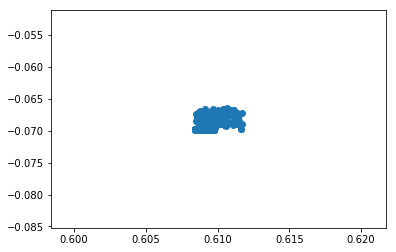

In [74]:
plt.scatter(ras, decs)
plt.show() 

In [ ]:
user_specs = {portion_of_sky:[], object_type:[], object_qualities:[],flags_to_not_cut_on:[]}

In [153]:
test = [False, True, True, False]
print ([elem for elem in test if elem == True ])

[True, True]
